# Kalman Filter (Forced Linear Advection Diffusion)

Kalman Filter のパッケージとしては pykalman(https://pykalman.github.io) があるが，<br>
Nan や観測データよりも細かいステップでの予測分布の更新など柔軟に対応できるプログラムを自分で作りたいというモチベーション

Kalman Filter について知りたい人は，以下の文献を参考にしてほしい．
- 樋口知之編著，上野玄太・中野慎也・中村和幸・吉田亮著，データ同化入門ー次世代のシミュレーション技術ー，朝倉書店，2011．
- 淡路敏之・蒲地政文・池田元美・石川洋一，データ同化ー観測・実験とモデルを融合するイノベーションー，京都大学学術出版会，2009．

## -----------コードを書く前の下準備----------

### 1d Forced Linear Advection Diffusion (外力項付き1次元線形移流拡散)

今回は，淡路他著の5.3節にある1次元移流線形拡散モデルを考える．支配方程式は以下で表せる．

$$
\begin{align*}
\frac{\partial C}{\partial t}=-u\frac{\partial C}{\partial x}+\nu\frac{\partial^2C}{\partial x^2}+w
\end{align*}
$$

ここで，$x$は東西の位置，$C$は物理量の濃度，$u$は移流速度，$\nu$は拡散係数，$w$は外力である．数値的安定性を考え，中心差分・二階差分を行うと，次のような更新式で表せる．

$$
\begin{align*}
&A_{t,i}=-u\frac{C_{t-1,i+1}-C_{t-1,i+1}}{2\Delta x}\\
&S_{t,i}=\nu\frac{C_{t-2,i+1}-2C_{t-2,i}+C_{t-2,i-1}}{(\Delta x)^2}\\
&C_{t,i}=C_{t-2,i}+2\Delta t(A_{t,i}+S_{t,i}+w_{t,i})
\end{align*}
$$

今回，移流速度・拡散係数は既知のものとして，$u=2.0,\nu=5.0$として双子実験を行う．また，東西400の40グリッド（$\Delta x=10$）とし，左右の境界では周期境界条件を適用した．$\Delta t=0.5$とし，タイムステップは$T=1200$(600秒)まで行うものとし，外力は次のように与えた．

$$w_{t,i}=F\sin\frac{\pi x}{60}\ (0\le x\le 60);\ 0\ (else)$$

### Twin Experiment (双子実験)

双子実験とは
- 決定論的シミュレーション+ノイズによって観測値を生成し，その観測値を用いてデータ同化をしたとき，どれぐらいフィットしているか確認する手法．
- 津波や地震等，特定の地点における観測を得たいと考えても，得られないケースが多いので，双子実験がよく用いられる．
- Lorenz63 model, Lorenz 96 model 等カオス系非線形方程式で試しにやってみることも多い

今回は，真値（完全シミュレーション），シミュレーション値(シミュレーションで使うパラメータ),観測値を次のようにセットアップする．
- 真値：初期値$C_{0,i}=0$，外力の時間変化は，
    $$F=\sin\frac{2\pi t}{120}+q,\ q\sim N(0,1.0)$$
    とした．
- シミュレーション値 : 初期値$C_{0,i}=0$，外力の時間変化は，
    $$F=\sin\frac{2\pi t}{120}$$
    とした．真の外力から$N(0,1.0)$の誤差を加えたものと考えられる．
- 観測値 : $t=375$から観測が始まり，15ステップごとに$160\le x\le 300$の範囲で20間隔ごとに観測が得られたとする．また，観測値は，
    $$C_{t,i}^{obs}=C_{t,i}^{true}+N(0,8.0^2)$$

これらのセットアップの元で，$t=360$から同化実験を開始する．

### Linear Gauss State Space Model（線形・ガウス状態空間モデル）

一般に，カルマンフィルタでは，線形・ガウス状態空間モデルを考える．これは，次の様に表せる．
$$
\begin{align}
&x_{t+1} = F_tx_t + b + N(0,Q_t)\\
&y_t = H_tx_t + d + N(0,R_t)
\end{align}
$$
ここで，$x_t$は時刻$t$における状態変数，$y_t$は時刻$t$における観測変数，$F_t$はシステム行列，$Q_t$はシステムノイズの共分散行列，$H_t$は観測行列，$R_t$は観測ノイズの共分散行列，$b,d$は各モデルのオフセット（切片）を表す．

今回の場合は，外力を考えて，
$$
\begin{align}
&x_{t+1} = F_tx_t + \Gamma_tw_t + G_tN(0,Q_t)\\
&y_t = H_tx_t + N(0,R_t)
\end{align}
$$
となるが，システムノイズは外力によってのみ生ずると仮定しているので，
$$
\begin{align}
&x_{t+1} = F_tx_t + G_tw_t + G_tN(0,Q_t)\\
&y_t = H_tx_t + N(0,R_t)
\end{align}
$$
と問題を考えれば良いことになる．

今回は，非線形システムなので，状態遷移行列$F_t$，外力行列$G_t$を直接得ることは難しく，近似的に設定する．具体的には，拡張カルマンフィルタの考え方に似たように，$F_t$の$n$番目の列ベクトルを
$$\mathbf{m}_n\simeq M(\bar{\mathbf{x}}+\mathbf{i}_n)-M(\bar{\mathbf{x}})$$
とする．ここで，$\bar{\mathbf{x}}$は平均などの代表値である．$G_t$も同様に$\mathbf{x}\to\mathbf{w}$として考える．<br>
時間ごとに$F_t,G_t$を変えて考えるべきかもしれないが，今回は時間に関する平均を取って$\bar{\mathbf{x}}$とし，時不変とする．

また，観測行列$H_t$は，観測がある地点のみ1を与え，それ以外では0を与える$8\times40$行列とする．

初期予測分布の分散共分散行列$V_{0|0}$，システムノイズ共分散行列$Q$，観測ノイズ共分散行列$R$は，以下のようになる．
$$V_{0|0}=8.0^2I_{40},\ Q=1.0^2I_{40},\ R=8.0^2I_8$$
ここで，$R$は観測値生成時の情報を用いて構成しているので，一般にはこんな簡単にセットアップしてはいけないことに注意したい．

### Kalman Filter Algorithm

カルマンフィルターのアルゴリズムは，以下であった．
1. 初期状態のフィルタ分布の平均 $x_{0|0}$，共分散行列$V_{0|0}$を与える
1. $t=1$から$T$まで次の予測ステップ・フィルタステップを繰り返す

予測ステップ
$$
\begin{gather}
x_{t|t-1}=F_tx_{t-1|t-1}\\
V_{t|t-1}=F_tV_{t-1|t-1}F_t^T+G_tQ_tG_t
\end{gather}
$$

フィルタステップ
$$
\begin{gather}
K_t = V_{t|t-1}H_t^T (H_tV_{t|t-1}H_t^T+R_t)^{-1}\\
x_{t|t} = x_{t|t-1}+K_t(y_t-H_tx_{t|t-1})\\
V_{t|t} = V_{t|t-1} - K_t H_t V_{t|t-1}
\end{gather}
$$

### RTS Smoothing Algorithm

カルマンフィルタによって，$x_{T|T},V_{T|T}$が得られたら，$t=T-1,\cdots,0$に対して，
$$
\begin{align*}
&A_t=V_{t|t}F_{t+1}^TV_{t+1|t}^{-1}\\
&x_{t|T} = x_{t|t} + A_t(x_{t+1|T} - x_{t+1|t})\\
&V_{t|T} = V_{t|t} + A_t(V_{t+1|T} - V_{t+1|t})A_t^T
\end{align*}
$$
によって固定区間平滑化分布の平均$x_{t|T}$と共分散行列$V_{t|T}$がわかる．ここで，$A_t$は固定区間平滑化ゲインと呼ばれている．

## ----------コード作成----------

ディレクトリ構造について
- DataAssimilation > try_and_error > Python_source : saving place for source
- DataAssimilation > try_and_error > plot : saving place for plot result

バージョンについて
- Mac OS 10.10
- Jupyter 4.3.0
- Python 3.6.1
- numpy 1.12.1
- pandas 0.20.1
- matplotlib 2.0.2
- seaborn 0.7.1
- scikit_learn 0.18.1
- scipy 0.19.0

作成フロー
- 真値，観測値，単純シミュレーション値生成関数
- 前進更新関数
- カルマンフィルター・スムーザークラス
- パラメータセッティング
- 実行，グラフ，結果評価

In [25]:
# install packages
import math
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy import interpolate

### 真値，観測値，単純シミュレーション値生成用関数

In [84]:
# 真値，観測値，単純シミュレーション値作成用 foward 関数
def Forward_generate (C, Cb, u, nu, w, dx, dt, t) :
    '''
    <Input Variables>
    C [n_dim] {numpy-array, float} : concentration, 物理量の濃度 C(t)
    Cb [n_dim] {numpy-array, float} : one step before concentration, 一期前の物理量の濃度 C(t-Δt)
    u {float} :  advection speed, 移流速度 u
    nu {float} : diffusion coefficient, 拡散係数 ν
    w [n_dim] {float} : outforce, 外力 w
    dx {float} : space resolution, 空間差分幅 Δx
    dt {float} : time resolution, 時間差分幅 Δt
    t {int} : step number, ステップナンバー t
    
    <Variables>
    L {int} : dimension of C, 濃度の次元
    A {float} : advection, 移流
    S {float} : diffusion, 拡散
    '''
    
    L = len(C)
    A = np.zeros(L)
    S = np.zeros(L)
    
    # 安定性確保のため15ステップに１回前進差分で更新
    '''
    if t%15 == 0:
        A[:L-1] = - u * (C[1:] - C[:L-1]) / dx
        A[L-1] = A[0]
    else :
    '''
    A[1:L-1] = - u * (C[2:] - C[:L-2]) / (2 * dx)
    # cyclic boundary condition, 周期境界条件
    A[0] = A[L - 2]
    A[L - 1] = A[1]
    
    S[1:L-1] = nu * (Cb[2:] - 2 * Cb[1:L-1] + Cb[:L-2]) / (dx * dx)
    # CBC
    S[0] = S[L - 2]
    S[L - 1] = S[1]
    
    C = Cb + 2 * dt * (A + S + w)
    return C

# generate true, observation, 真値，観測値生成関数
def Generate_true_observation (C_init, u, nu, w, dx, dt, T, obs_sd, obs_gen = True) :
    '''
    <Input Variables>
    C_init [n_dim] {float} : initial concentration, 初期濃度　C(t,0)
    u {float} :  advection speed, 移流速度 u
    nu {float} : diffusion coefficient, 拡散係数 ν
    w_without_F [n_dim] {float} : forcing function, 外力 w
    dx {float} : space resolution, 空間差分幅 Δx
    dt {float} : time resolution, 時間差分幅 Δt
    T {float} : end step number, 最終ステップナンバー T
    obs_sd {float} : standard deviation of observation noise, 観測ノイズの標準偏差
    obs_gen {boolean} : which is generated observation, 観測を生成するか否か
    
    <Variables in this function>
    L {int} : length of spatial, 空間の長さ L
    C_ture [time, n_dim] {numpy-array, float} : concentration, 濃度 C(t,x)
    C_obs [time, n_dim] {numpy-array, float} : concentration, 濃度 C(t,x)
    noise {float} : noise, ノイズ
    
    obs_gen True -> C_true, C_obs で真値，観測値生成
    obs_gen False -> C_true で単純シミュレーション値生成（input の w が異なる）
    '''
    
    L = len(C_init)
    
    # 周期境界条件のため，余分に取っておく
    C_true = np.zeros((T + 1, L + 1))
    
    if obs_gen :
        C_obs = np.zeros((T + 1, L + 1))
        C_obs[:, :] = np.nan
    
    C_true[0, :L] = C_init
    C_true[0, L] = C_true[0, 1]
    C_true[1] = C_true[0]
    for t in range(1, T) :
        # w はすでに線形補間されているとする．また，Fの計算はこの関数外（パラメータセッティングステップ）で行う
        C_true[t + 1] = Forward_generate(C_true[t], C_true[t-1], u, nu, np.append(w[t + 1], w[t + 1, 0]), dx, dt, t)
        
        # 観測値生成
        if obs_gen and t+1 >=375 and (t+1)%15==0 :
            noise = rd.normal(0, obs_sd, size = 8)
            C_obs[t+1, 16:31:2] = C_true[t+1, 16:31:2] + noise
    
    if obs_gen :
        return C_true[:, :L], C_obs[:, :L]
    else :
        return C_true[:, :L]

### カルマンフィルタークラス

In [78]:
class Kalman_Filter(object) :
    '''
    all numpy variable (numpy 変数で定義したものを入れる)
    コード上では，pred, filt が0:Tであり，tはtに対応している
    一方，smooth は 0:T-1であり，tはt-1に対応している

    <Input Variables>
    observation [time, n_dim_obs] {float} : observation y （観測値）
    initial_mean [time, n_dim_sys] {float} : initial state mean (初期フィルタ分布の平均)
    initial_covariance [n_dim_sys, n_dim_sys] {float} : initial state covariance （初期フィルタ分布の共分散行列）
    transition_matrix [n_dim_sys, n_dim_sys] {float} : transition matrix from x_{t-1} to x_t （システムモデルの変換行列）
    transition_noise_matrix [n_dim_noise, n_dim_sys] {float} : transition noise matrix (外力行列，ノイズ変換行列)
    observation_matrix [n_dim_sys, n_dim_obs] {float} : observation matrix （観測行列）
    transition_covariance [n_dim_sys, n_dim_sys] {float} : covariance of system noise （システムノイズの共分散行列）
    observation_covariance [n_dim_obs, n_dim_obs] {float} : covariance of observation noise （観測ノイズの共分散行列）
    transition_offsets [n_dim_sys] {float} : offsets of system transition model （システムモデルの切片 ＝ バイアス = オフセット）
    observation_offsets [n_dim_obs] {float} : offsets of observation model （観測モデルの切片 = バイアス = オフセット）
    n_dim_sys {int} : dimension of system variable （システム変数の次元）
    n_dim_obs {int} : dimension of observation variable （観測変数の次元）

    <Variables>
    y [time, n_dim_obs] {float} : observation y （観測値）
    F [n_dim_sys, n_dim_sys] {float} : transition matrix from x_{t-1} to x_t （システムモデルの変換行列）
    G [n_dim_noise, n_dim_sys] {float} : transition noise matrix (外力行列，ノイズ変換行列)
    Q [n_dim_sys, n_dim_sys] {float} : covariance of system noise （システムノイズの共分散行列）
    b [time, n_dim_sys] {float} : offsets of system transition model （システムモデルの切片 ＝ バイアス = オフセット）
    H [n_dim_sys, n_dim_obs] {float} : observation matrix （観測行列）
    R [n_dim_obs, n_dim_obs] {float} : covariance of observation noise （観測ノイズの共分散行列）
    d [time, n_dim_obs] {float} : offsets of observation model （観測モデルの切片 = バイアス = オフセット）
    x_pred [time, n_dim_sys] {float} :  mean of prediction distribution （予測分布の平均）
    V_pred [time, n_dim_sys, n_dim_sys] {float} : covariance of prediction distribution (予測分布の共分散行列)
    x_filt [time, n_dim_sys] {float} : mean of filtering distribution (フィルタ分布の平均)
    V_filt [time, n_dim_sys, n_dim_sys] {float} : covariance of filtering distribution (フィルタ分布の共分散行列)
    x_RTS [time, n_dim_sys] {float} : mean of RTS smoothing distribution (固定区間平滑化分布の平均)
    V_RTS [time, n_dim_sys, n_dim_sys] {float} : covariance of RTS smoothing distribution (固定区間平滑化の共分散行列)
    q_RTS [time, n_dim_force] {float} : mean of RTS smoothing forcing noise (外力ノイズの平滑化平均)
    Q_RTS [time, n_dim_force, n_dim_force] {float} : covariance of RTS smoothing forcing noise (外力ノイズの共分散行列)
    '''

    def __init__(self, observation, initial_mean, initial_covariance, transition_matrix, transition_noise_matrix,
                 observation_matrix, transition_covariance, observation_covariance, transition_offsets = None,
                 observation_offsets = None, n_dim_sys = None, n_dim_obs = None) :
        if n_dim_obs is None :
            self.y = observation
            self.n_dim_obs = self.y.shape[1]
        else :
            self.n_dim_obs = n_dim_obs
            if self.n_dim_obs != observation.shape[1] :
                raise IndexError('You mistake dimension of observation.')
            else :
                self.y = observation
        if n_dim_sys is None :
            self.initial_mean = initial_mean
            self.n_dim_sys = self.initial_mean.shape[0]
        else :
            self.n_dim_sys = n_dim_sys
            if self.n_dim_sys != initial_mean.shape[0] :
                raise IndexError('You mistake dimension of initial mean.')
            else :
                self.initial_mean = initial_mean
        self.initial_covariance = initial_covariance
        self.F = transition_matrix
        self.G = transition_noise_matrix
        self.Q = transition_covariance
        if transition_offsets is None :
            self.b = np.zeros(self.n_dim_sys)
        else :
            self.b = transition_offsets
        self.H = observation_matrix
        self.R = observation_covariance
        if observation_offsets is None :
            self.d = np.zeros(self.n_dim_obs)
        else :
            self.d = observation_offsets

    # filter function (フィルタ値を計算する関数)
    def Filter(self) :
        '''
        T : length of data y （時系列の長さ）
        K : Kalman gain (カルマンゲイン)
        '''
        T = len(self.y)
        self.x_pred = np.zeros((T + 1, self.n_dim_sys))
        self.V_pred = np.zeros((T + 1, self.n_dim_sys, self.n_dim_sys))
        self.x_filt = np.zeros((T + 1, self.n_dim_sys))
        self.V_filt = np.zeros((T + 1, self.n_dim_sys, self.n_dim_sys))

        # initial setting (初期分布)
        self.x_pred[0] = self.initial_mean
        self.V_pred[0] = self.initial_covariance
        self.x_filt[0] = self.initial_mean
        self.V_filt[0] = self.initial_covariance

        # GQG^T if G, Q, G is consistent
        GQG = np.dot(self.G, np.dot(self.Q, self.G.T))

        for t in range(T) :
            print("\r filter calculating... t={}".format(t + 1) + "/" + str(T), end="")

            # prediction (予測分布)
            # offset が時間依存するか否かで場合分け
            if self.b.ndim == 1:
                self.x_pred[t + 1] = np.dot(self.F, self.x_filt[t]) + self.b
            elif self.b.ndim == 2:
                self.x_pred[t + 1] = np.dot(self.F, self.x_filt[t]) + self.b[t]
            self.V_pred[t + 1] = np.dot(self.F, np.dot(self.V_filt[t], self.F.T)) + GQG
            
            if np.isnan(self.y[t]).any() :
                self.x_filt[t + 1] = self.x_pred[t + 1]
                self.V_filt[t + 1] = self.V_pred[t + 1]
            else :   
                # filtering (フィルタ分布)
                K = np.dot(self.V_pred[t + 1], np.dot(self.H.T, np.linalg.inv(np.dot(self.H, np.dot(self.V_pred[t + 1], self.H.T)) + self.R)))
                # offset が時間依存するか否かで場合分け
                if self.d.ndim == 1:
                    self.x_filt[t + 1] = self.x_pred[t + 1] + np.dot(K, self.y[t] - (np.dot(self.H, self.x_pred[t + 1]) + self.d))
                elif self.d.ndim == 2:
                    self.x_filt[t + 1] = self.x_pred[t + 1] + np.dot(K, self.y[t] - (np.dot(self.H, self.x_pred[t + 1]) + self.d[t]))
                self.V_filt[t + 1] = self.V_pred[t + 1] - np.dot(K, np.dot(self.H, self.V_pred[t + 1]))

    # get predicted value (一期先予測値を返す関数, Filter 関数後に値を得たい時)
    def Get_Predicted_Value(self) :
        return self.x_pred[1:]

    # get filtered value (フィルタ値を返す関数，Filter 関数後に値を得たい時)
    def Get_Filtered_Value(self) :
        return self.x_filt[1:]

    # RTS smooth function (RTSスムーシングを計算する関数，Filter 関数後に)
    def RTS_Smooth(self) :
        '''
        T : length of data y (時系列の長さ)
        A : fixed interval smoothed gain (固定区間平滑化ゲイン)
        FT : smoothed gain by control problem (制御問題の平滑化ゲイン)
        '''
        T = len(self.y)
        self.x_RTS = np.zeros((T, self.n_dim_sys))
        self.V_RTS = np.zeros((T, self.n_dim_sys, self.n_dim_sys))
        self.q_RTS = np.zeros((T, self.n_dim_sys))
        self.Q_RTS = np.zeros((T, self.n_dim_sys, self.n_dim_sys))

        self.x_RTS[T - 1] = self.x_filt[T]
        self.V_RTS[T - 1] = self.V_filt[T]

        FT = np.dot(self.Q, np.dot(self.G.T, np.linalg.inv(self.V_pred[T])))
        self.q_RTS[T - 1] = np.dot(FT, self.x_RTS[T - 1] - self.x_pred[T])
        self.Q_RTS[T - 1] = self.Q + np.dot(FT, np.dot(self.V_RTS[T - 1] - self.V_pred[T], FT.T))

        # t in [1, T] (tが1~Tの逆順であることに注意)
        for t in range(T - 1, 0, -1) :
            print("\r smooth calculating... t={}".format(T - t + 1) + "/" + str(T), end="")

            # fixed interval smoothing (固定区間平滑化分布)
            A = np.dot(self.V_filt[t], np.dot(self.F.T, np.linalg.inv(self.V_pred[t + 1])))
            self.x_RTS[t - 1] = self.x_filt[t] + np.dot(A, self.x_RTS[t] - self.x_pred[t + 1])
            self.V_RTS[t - 1] = self.V_filt[t] + np.dot(A, np.dot(self.V_RTS[t] - self.V_pred[t + 1], A.T))

    # get RTS smoothed value (RTS スムーシング値を返す関数，RTS_Smooth 後に)
    def Get_RTS_Smoothed_Value(self) :
        T = len(self.y)
        return self.x_RTS[:]

### 実行フェイズ

In [12]:
# true force, 真値の外力
def w_true_function (t, x, true_sd) :
    '''
    <Input Variable>
    t {float} : time, 時間
    x {float} : space, 空間
    true_sd {float} : standard deviation of true value, 真値生成時の標準偏差
    '''
    q = rd.normal(0, true_sd, size = 1)
    return (np.sin(np.pi * t / 60) + q) * np.sin(np.pi * x / 60)

# simulation force, シミュレーションの外力
def w_sim_function (t, x) :
    '''
    <Input Variables>
    t {float} : time, 時間
    x {float} : space, 空間
    '''
    return np.sin(np.pi * t / 60) * np.sin(np.pi * x / 60)

In [7]:
# decide parameters
n_dim_sys = 40
n_dim_obs = 8
u = 2.0
nu = 5.0
dx = 10
dt = 0.5
true_sd = 1.0
obs_sd = 8.0
T = 1200
L = 41

In [21]:
# decide initial state, outforce
C_init = np.zeros(L)
w_true = np.zeros((T + 1, L))
w_sim = np.zeros((T + 1, L))
for t in range(0, T + 1, 15) :
    for i in range(0, 7) :
        w_true[t, i] = w_true_function(t * dt, i * dx, true_sd)
        w_sim[t, i] = w_sim_function(t * dt, i * dx)

# linear interpolate, 線形補間
for i in range(0, 7):
    f1 = interpolate.interp1d(range(0, T + 1, 15), w_true[::15, i])
    w_true[:, i] = f1(np.linspace(0, T, T + 1))
    f2 = interpolate.interp1d(range(0, T + 1, 15), w_sim[::15, i])
    w_sim[:, i] = f2(np.linspace(0, T, T + 1))

In [20]:
print(w_true[:3])

[[  0.00000000e+00   3.48489561e-01   1.16162451e-01  -7.63107508e-01
    3.62629403e-02  -5.30881508e-01   4.13408106e-17   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   3.91841951e-01   5.58822074e-02  -7.25307084e-01
    9.25914293e-02  -5.21571249e-01   6.24370248e-17   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00


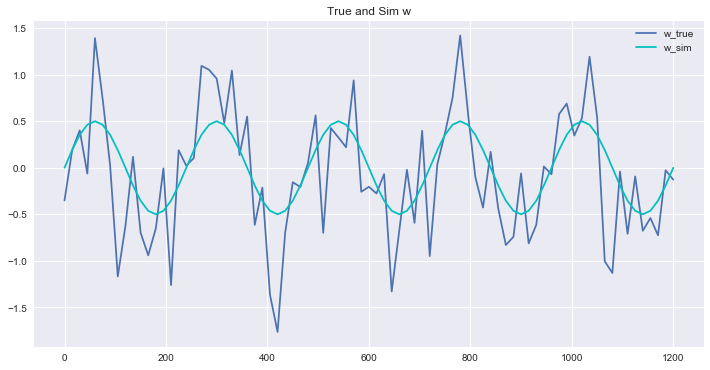

In [24]:
plt.figure(figsize = (12, 6))
plt.plot(w_true[:,1], label = 'w_true')
plt.plot(w_sim[:,1], color = 'c', label = 'w_sim')
plt.title("True and Sim w")
plt.legend(loc = 'best')
plt.show()

In [85]:
# 観測値，真値，単純シミュレーション値生成
C_true, C_obs = Generate_true_observation(C_init, u, nu, w_true, dx, dt, T, obs_sd)
C_sim = Generate_true_observation(C_init, u, nu, w_sim, dx, dt, T, obs_sd, False)

In [86]:
print(C_obs[375, 16:31:2])

[ -5.04045501   9.67883144 -20.24033154 -22.02017019 -14.25784162
 -23.44576624 -10.64412576   3.65159991]


In [87]:
# 状態遷移行列の決定
C_sim_mean = np.mean(C_sim, axis = 0)
w_sim_mean = np.mean(w_sim, axis = 0)
F = np.zeros((L, L))
G = np.zeros((L, L))
for i in range(L):
    # CBC してないのは見逃そう
    # C_up 二回使うのとかどうするんだって感じ
    C_up = C_sim_mean + np.insert(np.zeros(L-1), i, 1)
    amount_up = Forward_generate(C_up, C_up, u, nu, w_sim_mean, dx, dt, 1)
    amount_down = Forward_generate(C_sim_mean, C_sim_mean, u, nu, w_sim_mean, dx, dt, 1)
    F[i] = amount_up - amount_down
    
    w_up = w_sim_mean + np.insert(np.zeros(L-1), i, 1)
    amount_up = Forward_generate(C_sim_mean, C_sim_mean, u, nu, w_up, dx, dt, 1)
    amount_down = Forward_generate(C_sim_mean, C_sim_mean, u, nu, w_sim_mean, dx, dt, 1)
    G[i] = amount_up - amount_down

In [88]:
print(F)
print(G)

[[ 1.    0.15  0.   ...,  0.    0.    0.15]
 [ 0.    0.9   0.15 ...,  0.    0.   -0.1 ]
 [ 0.   -0.05  0.9  ...,  0.    0.   -0.05]
 ..., 
 [ 0.15  0.    0.   ...,  0.9   0.15  0.  ]
 [-0.1   0.    0.   ..., -0.05  0.9   0.  ]
 [-0.05  0.    0.   ...,  0.   -0.05  1.  ]]
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


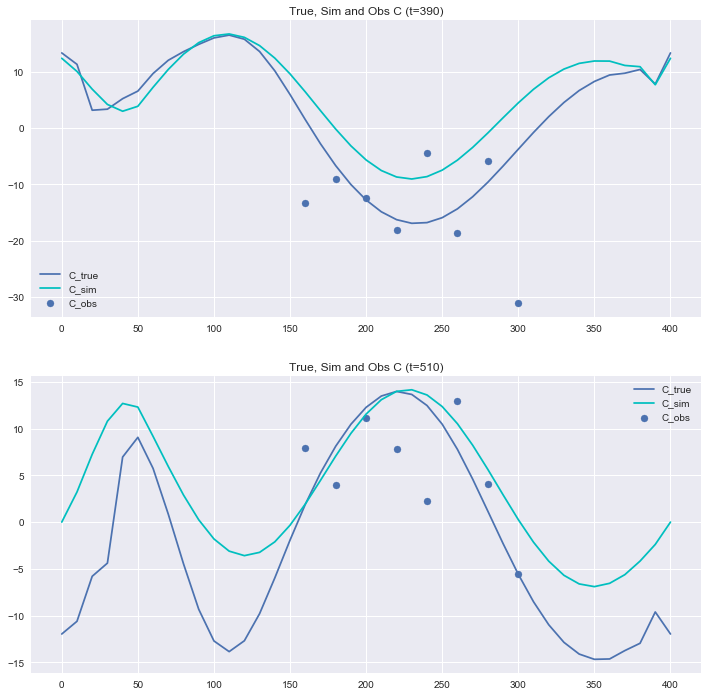

In [89]:
plt.figure(figsize = (12, 12))
plt.subplot(2, 1, 1)
plt.scatter(range(160, 301, 20), C_obs[390, 16:31:2], label = 'C_obs')
plt.plot(range(0, 401, 10), C_true[390], label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[390], color = 'c', label = 'C_sim')
plt.title("True, Sim and Obs C (t=390)")
plt.legend(loc = 'best')

plt.subplot(2, 1, 2)
plt.scatter(range(160, 301, 20), C_obs[510, 16:31:2], label = 'C_obs')
plt.plot(range(0, 401, 10), C_true[510], label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[510], color = 'c', label = 'C_sim')
plt.title("True, Sim and Obs C (t=510)")
plt.legend(loc = 'best')

plt.show()

In [90]:
# setup matrix
H = np.zeros((8, L))
for i in range(8):
    H[i, 16 + 2 * i] = 1

Gw = np.dot(G, w_sim.T).T
V0 = obs_sd**2 * np.eye(L)
Q = true_sd**2 * np.eye(L)
R = obs_sd**2 * np.eye(8)

In [91]:
# confirmation
print(F.shape)
print(G.shape)
print(H.shape)
print(Gw.shape)
print(V0.shape)
print(Q.shape)
print(R.shape)

(41, 41)
(41, 41)
(8, 41)
(1201, 41)
(41, 41)
(41, 41)
(8, 8)


In [92]:
kf = Kalman_Filter(C_obs, C_init, V0, F, G, H, Q, R, Gw)
kf.Filter()
kf.RTS_Smooth()

 filter calculating... t=601/1201

 filter calculating... t=1201/1201

 smooth calculating... t=544/1201

 smooth calculating... t=987/1201

 smooth calculating... t=1201/1201

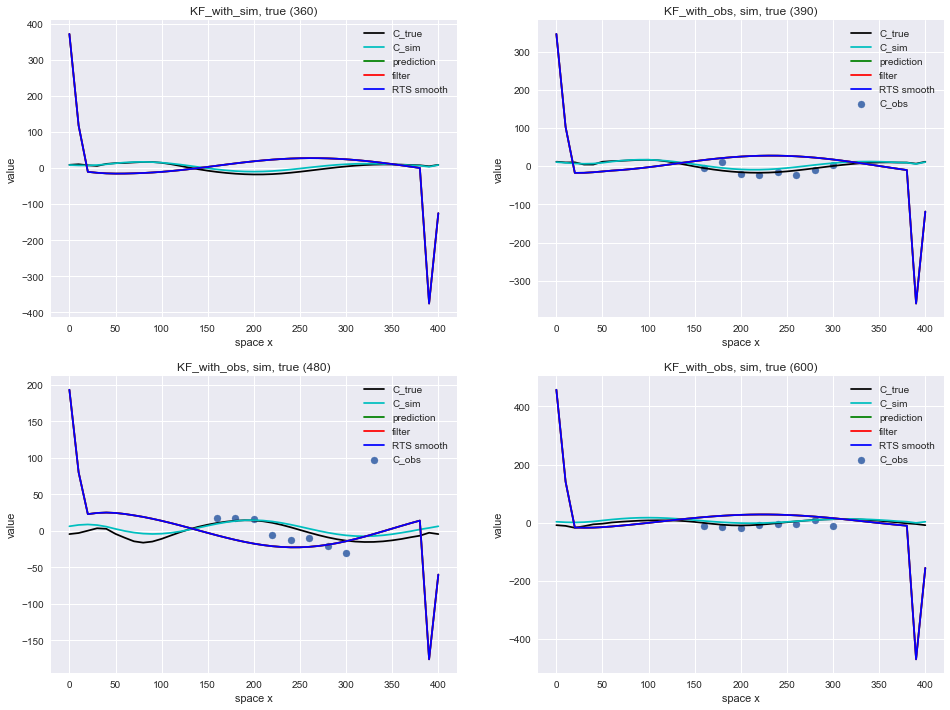

In [93]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(range(0, 401, 10), C_true[360], color = 'k', label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[360], color = 'c', label = 'C_sim')
plt.plot(range(0, 401, 10),kf.Get_Predicted_Value()[360], color = 'g', label =  'prediction')
plt.plot(range(0, 401, 10),kf.Get_Filtered_Value()[360], color = "r", label = "filter")
plt.plot(range(0, 401, 10),kf.Get_RTS_Smoothed_Value()[360], color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('space x')
plt.ylabel('value')
plt.title("KF_with_sim, true (360)")

plt.subplot(2, 2, 2)
plt.scatter(range(160, 301, 20), C_obs[375, 16:31:2], label = 'C_obs')
plt.plot(range(0, 401, 10), C_true[375], color = 'k', label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[375], color = 'c', label = 'C_sim')
plt.plot(range(0, 401, 10),kf.Get_Predicted_Value()[375], color = 'g', label =  'prediction')
plt.plot(range(0, 401, 10),kf.Get_Filtered_Value()[375], color = "r", label = "filter")
plt.plot(range(0, 401, 10),kf.Get_RTS_Smoothed_Value()[375], color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('space x')
plt.ylabel('value')
plt.title("KF_with_obs, sim, true (390)")

plt.subplot(2, 2, 3)
plt.scatter(range(160, 301, 20), C_obs[480, 16:31:2], label = 'C_obs')
plt.plot(range(0, 401, 10), C_true[480], color = 'k', label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[480], color = 'c', label = 'C_sim')
plt.plot(range(0, 401, 10),kf.Get_Predicted_Value()[480], color = 'g', label =  'prediction')
plt.plot(range(0, 401, 10),kf.Get_Filtered_Value()[480], color = "r", label = "filter")
plt.plot(range(0, 401, 10),kf.Get_RTS_Smoothed_Value()[480], color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('space x')
plt.ylabel('value')
plt.title("KF_with_obs, sim, true (480)")

plt.subplot(2, 2, 4)
plt.scatter(range(160, 301, 20), C_obs[600, 16:31:2], label = 'C_obs')
plt.plot(range(0, 401, 10), C_true[600], color = 'k', label = 'C_true')
plt.plot(range(0, 401, 10), C_sim[600], color = 'c', label = 'C_sim')
plt.plot(range(0, 401, 10),kf.Get_Predicted_Value()[600], color = 'g', label =  'prediction')
plt.plot(range(0, 401, 10),kf.Get_Filtered_Value()[600], color = "r", label = "filter")
plt.plot(range(0, 401, 10),kf.Get_RTS_Smoothed_Value()[600], color = 'b', label = 'RTS smooth')
plt.legend(loc = 'best')
plt.xlabel('space x')
plt.ylabel('value')
plt.title("KF_with_obs, sim, true (600)")

plt.savefig("../plot/171224_KF_RTS_concentration.png")
plt.show()

今日の感想
- filter, prediction, smoothing のプログラムは前回の流用している（isnanだけ変えた）から問題ないはず
- filter, prediction, smoothing の値が完全に一致しているのは更新が小さいからだろう．すなわち，F,Gの作り方がまずいのだろう．
- F,G の作り方が結局よくわからない．

### MSE, RMSE (結果の評価)

In [153]:
mse = np.zeros(5)
mse[0] = MSE(C_true, x_sim)
mse[1] = MSE(C_true, x_obs)
mse[2] = MSE(C_true, kf.Get_Predicted_Value()[600])
mse[3] = MSE(C_true, kf.Get_Filtered_Value()[600])
mse[4] = MSE(C_true, kf.Get_RTS_Smoothed_Value()[600])
df_mse = pd.DataFrame(mse, index = ['simple simulation', 'observation', 'prediction', 'filter', 'RTS smooth'], columns = ['C(600)'])
df_mse

,x,v,w
perfect simulation,1.836136,0.688785,0.328104
observation,1.683725,0.591789,0.437563
prediction,1.670310,1.013257,0.000000
filter,1.166836,0.997252,0.000000
RTS smooth,1.006116,0.598276,0.207537


In [154]:
rmse = np.sqrt(mse)
df_rmse = pd.DataFrame(rmse, index = ['simple simulation', 'observation', 'prediction', 'filter', 'RTS smooth'], columns = ['C(600)'])
df_rmse

,x,v,w
perfect simulation,1.355041,0.829931,0.572803
observation,1.297584,0.769279,0.661485
prediction,1.292405,1.006607,0.000000
filter,1.080202,0.998625,0.000000
RTS smooth,1.003053,0.773483,0.455563
